## __6장 학습 관련 기술들__
<br>

### 6.1 매개변수 갱신

In [1]:
# 확률적 경사하강법 SGD
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [2]:
# 모멘텀 momentum
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key] 

In [3]:
# AdaGrad
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) 

### 6.2 가중치 초깃값

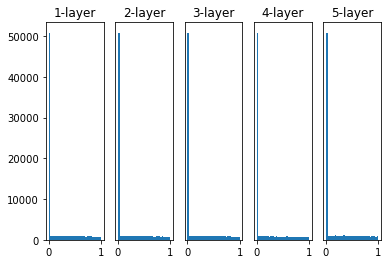

In [15]:
# 가중치 초깃값에 따른 은닉층 활성화값들의 변화
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
std=0.01:2.3024886108979574
Xavier:2.3107140854934007
He:2.314153328564016
===========iteration:100===========
std=0.01:2.3016652628051486
Xavier:2.2412729747850335
He:1.2737181094703396
===========iteration:200===========
std=0.01:2.3015204511450817
Xavier:2.126234356237024
He:0.6756830668988755
===========iteration:300===========
std=0.01:2.30005755714477
Xavier:1.8560411721768808
He:0.46071757586150175
===========iteration:400===========
std=0.01:2.3017301019701155
Xavier:1.2363618103339948
He:0.30856071365845034
===========iteration:500===========
std=0.01:2.299163208155086
Xavier:0.8923063602069533
He:0.39885998286224
===========iteration:600===========
std=0.01:2.2979874935233813
Xavier:0.7623571246253662
He:0.4077822133662193
===========iteration:700===========
std=0.01:2.2970262934035546
Xavier:0.5381218875204465
He:0.35216412444279255
===========iteration:800===========
std=0.01:2.3041314379874285
Xavier:0.6087129921458649
He:0.416246782272633

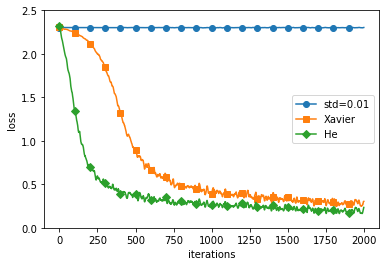

In [16]:
# MNIST 가중치 초깃값 비교
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show() 

### 6.3 배치 정규화

============== 1/16 ==============
epoch:0 | 0.087 - 0.067


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.1 - 0.075
epoch:2 | 0.1 - 0.129
epoch:3 | 0.1 - 0.15
epoch:4 | 0.1 - 0.17
epoch:5 | 0.097 - 0.2
epoch:6 | 0.097 - 0.223
epoch:7 | 0.097 - 0.245
epoch:8 | 0.097 - 0.269
epoch:9 | 0.117 - 0.277
epoch:10 | 0.117 - 0.294
epoch:11 | 0.117 - 0.322
epoch:12 | 0.117 - 0.342
epoch:13 | 0.117 - 0.372
epoch:14 | 0.117 - 0.38
epoch:15 | 0.117 - 0.396
epoch:16 | 0.117 - 0.398
epoch:17 | 0.117 - 0.415
epoch:18 | 0.117 - 0.432


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.451
============== 2/16 ==============
epoch:0 | 0.105 - 0.099


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:1 | 0.097 - 0.139
epoch:2 | 0.097 - 0.162
epoch:3 | 0.097 - 0.188
epoch:4 | 0.097 - 0.198
epoch:5 | 0.097 - 0.232
epoch:6 | 0.097 - 0.248
epoch:7 | 0.097 - 0.267
epoch:8 | 0.097 - 0.295
epoch:9 | 0.097 - 0.324
epoch:10 | 0.097 - 0.337
epoch:11 | 0.097 - 0.356
epoch:12 | 0.097 - 0.375
epoch:13 | 0.097 - 0.395
epoch:14 | 0.097 - 0.413
epoch:15 | 0.097 - 0.435
epoch:16 | 0.097 - 0.447
epoch:17 | 0.097 - 0.46
epoch:18 | 0.097 - 0.47


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.494
============== 3/16 ==============
epoch:0 | 0.117 - 0.091
epoch:1 | 0.286 - 0.129
epoch:2 | 0.442 - 0.191
epoch:3 | 0.521 - 0.238
epoch:4 | 0.569 - 0.282
epoch:5 | 0.655 - 0.32
epoch:6 | 0.691 - 0.355
epoch:7 | 0.726 - 0.383
epoch:8 | 0.763 - 0.423
epoch:9 | 0.79 - 0.456
epoch:10 | 0.813 - 0.482
epoch:11 | 0.826 - 0.505
epoch:12 | 0.854 - 0.534
epoch:13 | 0.868 - 0.552
epoch:14 | 0.887 - 0.567
epoch:15 | 0.898 - 0.59
epoch:16 | 0.905 - 0.602
epoch:17 | 0.916 - 0.618
epoch:18 | 0.93 - 0.629
epoch:19 | 0.939 - 0.646


No handles with labels found to put in legend.


============== 4/16 ==============
epoch:0 | 0.138 - 0.076
epoch:1 | 0.239 - 0.1
epoch:2 | 0.415 - 0.159
epoch:3 | 0.501 - 0.234
epoch:4 | 0.591 - 0.306
epoch:5 | 0.648 - 0.396
epoch:6 | 0.679 - 0.467
epoch:7 | 0.714 - 0.508
epoch:8 | 0.725 - 0.555
epoch:9 | 0.757 - 0.583
epoch:10 | 0.762 - 0.614
epoch:11 | 0.793 - 0.638
epoch:12 | 0.807 - 0.665
epoch:13 | 0.815 - 0.689
epoch:14 | 0.826 - 0.7
epoch:15 | 0.836 - 0.731
epoch:16 | 0.848 - 0.734
epoch:17 | 0.856 - 0.749
epoch:18 | 0.863 - 0.758


No handles with labels found to put in legend.


epoch:19 | 0.87 - 0.767
============== 5/16 ==============
epoch:0 | 0.088 - 0.095
epoch:1 | 0.095 - 0.173
epoch:2 | 0.096 - 0.306
epoch:3 | 0.102 - 0.455
epoch:4 | 0.104 - 0.545
epoch:5 | 0.109 - 0.623
epoch:6 | 0.114 - 0.671
epoch:7 | 0.121 - 0.694
epoch:8 | 0.127 - 0.734
epoch:9 | 0.135 - 0.762
epoch:10 | 0.161 - 0.779
epoch:11 | 0.175 - 0.798
epoch:12 | 0.187 - 0.81
epoch:13 | 0.208 - 0.832
epoch:14 | 0.208 - 0.844
epoch:15 | 0.231 - 0.847
epoch:16 | 0.246 - 0.859
epoch:17 | 0.26 - 0.869
epoch:18 | 0.26 - 0.876


No handles with labels found to put in legend.


epoch:19 | 0.279 - 0.891
============== 6/16 ==============
epoch:0 | 0.095 - 0.102
epoch:1 | 0.082 - 0.206
epoch:2 | 0.117 - 0.389
epoch:3 | 0.117 - 0.54
epoch:4 | 0.117 - 0.668
epoch:5 | 0.118 - 0.732
epoch:6 | 0.117 - 0.766
epoch:7 | 0.117 - 0.811
epoch:8 | 0.169 - 0.826
epoch:9 | 0.139 - 0.851
epoch:10 | 0.118 - 0.865
epoch:11 | 0.117 - 0.879
epoch:12 | 0.117 - 0.887
epoch:13 | 0.117 - 0.902
epoch:14 | 0.117 - 0.906
epoch:15 | 0.117 - 0.917
epoch:16 | 0.117 - 0.926
epoch:17 | 0.117 - 0.929
epoch:18 | 0.117 - 0.939


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.945
============== 7/16 ==============
epoch:0 | 0.129 - 0.113
epoch:1 | 0.116 - 0.318
epoch:2 | 0.15 - 0.6
epoch:3 | 0.117 - 0.706
epoch:4 | 0.117 - 0.762
epoch:5 | 0.117 - 0.81
epoch:6 | 0.117 - 0.846
epoch:7 | 0.117 - 0.868
epoch:8 | 0.117 - 0.893
epoch:9 | 0.117 - 0.912
epoch:10 | 0.117 - 0.921
epoch:11 | 0.117 - 0.938
epoch:12 | 0.117 - 0.948
epoch:13 | 0.117 - 0.96
epoch:14 | 0.117 - 0.958
epoch:15 | 0.117 - 0.969
epoch:16 | 0.117 - 0.972
epoch:17 | 0.117 - 0.979
epoch:18 | 0.117 - 0.983
epoch:19 | 0.117 - 0.985


No handles with labels found to put in legend.


============== 8/16 ==============
epoch:0 | 0.116 - 0.129
epoch:1 | 0.116 - 0.377
epoch:2 | 0.116 - 0.605
epoch:3 | 0.116 - 0.752
epoch:4 | 0.116 - 0.794
epoch:5 | 0.116 - 0.853
epoch:6 | 0.116 - 0.892
epoch:7 | 0.116 - 0.925
epoch:8 | 0.116 - 0.951
epoch:9 | 0.116 - 0.975
epoch:10 | 0.116 - 0.981
epoch:11 | 0.116 - 0.985
epoch:12 | 0.116 - 0.986
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.994
epoch:15 | 0.116 - 0.995
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.097 - 0.083
epoch:1 | 0.117 - 0.587
epoch:2 | 0.117 - 0.765
epoch:3 | 0.117 - 0.861
epoch:4 | 0.117 - 0.92
epoch:5 | 0.117 - 0.94
epoch:6 | 0.117 - 0.965
epoch:7 | 0.117 - 0.973
epoch:8 | 0.117 - 0.982
epoch:9 | 0.117 - 0.987
epoch:10 | 0.117 - 0.992
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.995
epoch:17 | 0.117 - 0.996
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 10/16 ==============
epoch:0 | 0.099 - 0.104
epoch:1 | 0.117 - 0.525
epoch:2 | 0.116 - 0.707
epoch:3 | 0.116 - 0.81
epoch:4 | 0.116 - 0.78
epoch:5 | 0.116 - 0.858
epoch:6 | 0.116 - 0.871
epoch:7 | 0.116 - 0.937
epoch:8 | 0.116 - 0.973
epoch:9 | 0.116 - 0.975
epoch:10 | 0.116 - 0.96
epoch:11 | 0.116 - 0.991
epoch:12 | 0.116 - 0.992
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.993
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.989
epoch:18 | 0.116 - 0.996


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.997
============== 11/16 ==============
epoch:0 | 0.094 - 0.265
epoch:1 | 0.116 - 0.68
epoch:2 | 0.116 - 0.688
epoch:3 | 0.117 - 0.717
epoch:4 | 0.116 - 0.783
epoch:5 | 0.116 - 0.84
epoch:6 | 0.116 - 0.724
epoch:7 | 0.116 - 0.877
epoch:8 | 0.116 - 0.887
epoch:9 | 0.116 - 0.888
epoch:10 | 0.116 - 0.977
epoch:11 | 0.116 - 0.98
epoch:12 | 0.116 - 0.982
epoch:13 | 0.116 - 0.976
epoch:14 | 0.116 - 0.982
epoch:15 | 0.116 - 0.934
epoch:16 | 0.116 - 0.866
epoch:17 | 0.116 - 0.983
epoch:18 | 0.116 - 0.99


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.991
============== 12/16 ==============
epoch:0 | 0.117 - 0.149
epoch:1 | 0.117 - 0.553
epoch:2 | 0.117 - 0.578
epoch:3 | 0.117 - 0.658
epoch:4 | 0.117 - 0.64
epoch:5 | 0.117 - 0.675
epoch:6 | 0.117 - 0.635
epoch:7 | 0.117 - 0.697
epoch:8 | 0.117 - 0.703
epoch:9 | 0.117 - 0.693
epoch:10 | 0.117 - 0.673
epoch:11 | 0.117 - 0.709
epoch:12 | 0.117 - 0.715
epoch:13 | 0.117 - 0.718
epoch:14 | 0.117 - 0.715
epoch:15 | 0.117 - 0.716
epoch:16 | 0.117 - 0.717
epoch:17 | 0.117 - 0.72
epoch:18 | 0.117 - 0.717


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.712
============== 13/16 ==============
epoch:0 | 0.105 - 0.189
epoch:1 | 0.117 - 0.422
epoch:2 | 0.116 - 0.498
epoch:3 | 0.116 - 0.461
epoch:4 | 0.116 - 0.527
epoch:5 | 0.116 - 0.581
epoch:6 | 0.116 - 0.682
epoch:7 | 0.116 - 0.681
epoch:8 | 0.117 - 0.694
epoch:9 | 0.117 - 0.699
epoch:10 | 0.117 - 0.704
epoch:11 | 0.117 - 0.709
epoch:12 | 0.117 - 0.704
epoch:13 | 0.117 - 0.707
epoch:14 | 0.117 - 0.707
epoch:15 | 0.117 - 0.704
epoch:16 | 0.117 - 0.709
epoch:17 | 0.117 - 0.707
epoch:18 | 0.117 - 0.708


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.71
============== 14/16 ==============
epoch:0 | 0.097 - 0.137
epoch:1 | 0.117 - 0.331
epoch:2 | 0.116 - 0.279
epoch:3 | 0.116 - 0.403
epoch:4 | 0.116 - 0.417
epoch:5 | 0.116 - 0.425
epoch:6 | 0.116 - 0.424
epoch:7 | 0.117 - 0.427
epoch:8 | 0.117 - 0.391
epoch:9 | 0.117 - 0.427
epoch:10 | 0.117 - 0.43
epoch:11 | 0.117 - 0.432
epoch:12 | 0.117 - 0.432
epoch:13 | 0.117 - 0.523
epoch:14 | 0.117 - 0.507
epoch:15 | 0.117 - 0.502
epoch:16 | 0.117 - 0.518
epoch:17 | 0.117 - 0.514
epoch:18 | 0.117 - 0.514


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.527
============== 15/16 ==============
epoch:0 | 0.093 - 0.24
epoch:1 | 0.097 - 0.325
epoch:2 | 0.116 - 0.279
epoch:3 | 0.116 - 0.487
epoch:4 | 0.116 - 0.488
epoch:5 | 0.116 - 0.462
epoch:6 | 0.116 - 0.497
epoch:7 | 0.116 - 0.493
epoch:8 | 0.116 - 0.504
epoch:9 | 0.116 - 0.499
epoch:10 | 0.116 - 0.523
epoch:11 | 0.116 - 0.518
epoch:12 | 0.116 - 0.518
epoch:13 | 0.116 - 0.505
epoch:14 | 0.116 - 0.497
epoch:15 | 0.116 - 0.524
epoch:16 | 0.116 - 0.463
epoch:17 | 0.116 - 0.525
epoch:18 | 0.116 - 0.526


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.532
============== 16/16 ==============
epoch:0 | 0.116 - 0.18
epoch:1 | 0.117 - 0.118
epoch:2 | 0.117 - 0.276
epoch:3 | 0.116 - 0.408
epoch:4 | 0.116 - 0.413
epoch:5 | 0.116 - 0.417
epoch:6 | 0.116 - 0.422
epoch:7 | 0.116 - 0.427
epoch:8 | 0.117 - 0.429
epoch:9 | 0.117 - 0.43
epoch:10 | 0.116 - 0.506
epoch:11 | 0.117 - 0.5
epoch:12 | 0.116 - 0.493
epoch:13 | 0.116 - 0.508
epoch:14 | 0.116 - 0.441
epoch:15 | 0.117 - 0.473
epoch:16 | 0.117 - 0.513
epoch:17 | 0.116 - 0.521
epoch:18 | 0.116 - 0.516
epoch:19 | 0.117 - 0.526


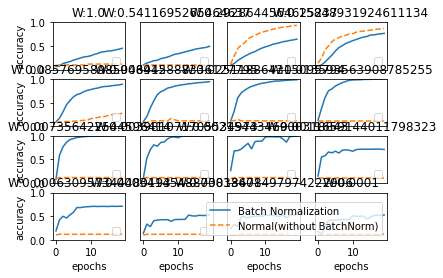

In [17]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show() 

### 6.4 바른 학습!

epoch:0, train acc:0.12666666666666668, test acc:0.1061
epoch:1, train acc:0.14, test acc:0.1132
epoch:2, train acc:0.14333333333333334, test acc:0.1188
epoch:3, train acc:0.14333333333333334, test acc:0.1274
epoch:4, train acc:0.15333333333333332, test acc:0.1367
epoch:5, train acc:0.16, test acc:0.1473
epoch:6, train acc:0.18, test acc:0.1575
epoch:7, train acc:0.18, test acc:0.1649
epoch:8, train acc:0.18666666666666668, test acc:0.1763
epoch:9, train acc:0.2, test acc:0.1784
epoch:10, train acc:0.20333333333333334, test acc:0.1841
epoch:11, train acc:0.23, test acc:0.1932
epoch:12, train acc:0.24333333333333335, test acc:0.2003
epoch:13, train acc:0.27, test acc:0.2117
epoch:14, train acc:0.28, test acc:0.2181
epoch:15, train acc:0.29333333333333333, test acc:0.2288
epoch:16, train acc:0.3233333333333333, test acc:0.2412
epoch:17, train acc:0.35333333333333333, test acc:0.2574
epoch:18, train acc:0.37, test acc:0.2725
epoch:19, train acc:0.39666666666666667, test acc:0.2857
epoch:2

epoch:159, train acc:0.89, test acc:0.7174
epoch:160, train acc:0.8833333333333333, test acc:0.7132
epoch:161, train acc:0.89, test acc:0.7204
epoch:162, train acc:0.8833333333333333, test acc:0.7182
epoch:163, train acc:0.87, test acc:0.7035
epoch:164, train acc:0.8866666666666667, test acc:0.7106
epoch:165, train acc:0.89, test acc:0.7103
epoch:166, train acc:0.8966666666666666, test acc:0.7192
epoch:167, train acc:0.8966666666666666, test acc:0.7119
epoch:168, train acc:0.8833333333333333, test acc:0.7152
epoch:169, train acc:0.8966666666666666, test acc:0.723
epoch:170, train acc:0.9, test acc:0.7214
epoch:171, train acc:0.8966666666666666, test acc:0.7162
epoch:172, train acc:0.8733333333333333, test acc:0.7129
epoch:173, train acc:0.8933333333333333, test acc:0.7143
epoch:174, train acc:0.8933333333333333, test acc:0.7175
epoch:175, train acc:0.9, test acc:0.7159
epoch:176, train acc:0.8933333333333333, test acc:0.7163
epoch:177, train acc:0.89, test acc:0.7082
epoch:178, train a

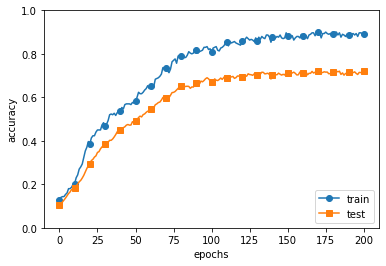

In [18]:
# 오버피팅
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show() 

In [19]:
# Drop out
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.294441672791068
=== epoch:1, train acc:0.1, test acc:0.1049 ===
train loss:2.315202701569872
train loss:2.3078852334283395
train loss:2.28866528660668
=== epoch:2, train acc:0.1, test acc:0.1087 ===
train loss:2.289027683501486
train loss:2.2976755545657874
train loss:2.2909125501103027
=== epoch:3, train acc:0.10333333333333333, test acc:0.1111 ===
train loss:2.2873780143789104
train loss:2.298642013756733
train loss:2.289516113617317
=== epoch:4, train acc:0.11333333333333333, test acc:0.1141 ===
train loss:2.267668455694525
train loss:2.304951946539971
train loss:2.2989313120627153
=== epoch:5, train acc:0.12, test acc:0.116 ===
train loss:2.279119466599496
train loss:2.303348176975351
train loss:2.2842730792992954
=== epoch:6, train acc:0.11666666666666667, test acc:0.1193 ===
train loss:2.2828974891735108
train loss:2.2916355934261596
train loss:2.2900743713464164
=== epoch:7, train acc:0.10666666666666667, test acc:0.1195 ===
train loss:2.3187224271056297
train loss:

=== epoch:56, train acc:0.26666666666666666, test acc:0.2438 ===
train loss:2.2220865178690246
train loss:2.2341567250202665
train loss:2.2112452724346494
=== epoch:57, train acc:0.26, test acc:0.2447 ===
train loss:2.2429456515077946
train loss:2.240506680362923
train loss:2.2171024829242567
=== epoch:58, train acc:0.2733333333333333, test acc:0.2492 ===
train loss:2.226708678007364
train loss:2.2359882148869454
train loss:2.244638497465696
=== epoch:59, train acc:0.28, test acc:0.2551 ===
train loss:2.230993274432492
train loss:2.2396660787216076
train loss:2.2410198715315435
=== epoch:60, train acc:0.28, test acc:0.2556 ===
train loss:2.212216448261069
train loss:2.1927379264136695
train loss:2.2406502329182887
=== epoch:61, train acc:0.2833333333333333, test acc:0.2545 ===
train loss:2.2446917797154717
train loss:2.2463771463050044
train loss:2.2438431423162104
=== epoch:62, train acc:0.2733333333333333, test acc:0.2553 ===
train loss:2.2248203203013164
train loss:2.227186825691590

=== epoch:112, train acc:0.33666666666666667, test acc:0.3013 ===
train loss:2.0919012723046233
train loss:2.1104284233387993
train loss:2.0987523407681503
=== epoch:113, train acc:0.3466666666666667, test acc:0.3026 ===
train loss:2.1411490954086245
train loss:2.105963574441511
train loss:2.0775787363625895
=== epoch:114, train acc:0.35, test acc:0.3068 ===
train loss:2.1240149159481385
train loss:2.0788422130036084
train loss:2.075386503824288
=== epoch:115, train acc:0.34, test acc:0.3029 ===
train loss:2.1143738998636814
train loss:2.135816211867293
train loss:2.0906365416972896
=== epoch:116, train acc:0.34, test acc:0.3037 ===
train loss:2.080987124729282
train loss:2.105057062932522
train loss:2.0968318125325256
=== epoch:117, train acc:0.33666666666666667, test acc:0.3047 ===
train loss:2.108634200853249
train loss:2.0949546637330205
train loss:2.1243382653646883
=== epoch:118, train acc:0.3433333333333333, test acc:0.311 ===
train loss:2.0710522633028914
train loss:2.144536192

=== epoch:167, train acc:0.46, test acc:0.3599 ===
train loss:1.8723734483220356
train loss:1.8294884310298085
train loss:1.8532382562303473
=== epoch:168, train acc:0.45666666666666667, test acc:0.3592 ===
train loss:1.9354333378391595
train loss:1.846292554965039
train loss:1.8611545175488322
=== epoch:169, train acc:0.44666666666666666, test acc:0.3592 ===
train loss:1.938962891170472
train loss:1.8447923326204967
train loss:1.8220379394366015
=== epoch:170, train acc:0.45666666666666667, test acc:0.3611 ===
train loss:1.8232330619286625
train loss:1.8055165074977466
train loss:1.8472592526905982
=== epoch:171, train acc:0.45666666666666667, test acc:0.3619 ===
train loss:1.874737190864449
train loss:1.8217594843888762
train loss:1.804670989029149
=== epoch:172, train acc:0.4666666666666667, test acc:0.3633 ===
train loss:1.8827858325723712
train loss:1.8229559450327644
train loss:1.7235397452693568
=== epoch:173, train acc:0.44333333333333336, test acc:0.3586 ===
train loss:1.83222

=== epoch:223, train acc:0.5533333333333333, test acc:0.4349 ===
train loss:1.6019115813767377
train loss:1.5618686598301648
train loss:1.5652580967917746
=== epoch:224, train acc:0.5666666666666667, test acc:0.4385 ===
train loss:1.5665845145722457
train loss:1.5039339515647294
train loss:1.4488840010070694
=== epoch:225, train acc:0.5566666666666666, test acc:0.4378 ===
train loss:1.5413665711802826
train loss:1.5664464442746704
train loss:1.533726757543761
=== epoch:226, train acc:0.5566666666666666, test acc:0.4379 ===
train loss:1.4854903889366597
train loss:1.6672183002171954
train loss:1.4190083250594563
=== epoch:227, train acc:0.5566666666666666, test acc:0.437 ===
train loss:1.608606018593723
train loss:1.374539850463766
train loss:1.6326049828691627
=== epoch:228, train acc:0.5566666666666666, test acc:0.4402 ===
train loss:1.4693664799370196
train loss:1.6244210799313206
train loss:1.5402360212982305
=== epoch:229, train acc:0.5666666666666667, test acc:0.4415 ===
train los

=== epoch:278, train acc:0.6266666666666667, test acc:0.4924 ===
train loss:1.2922011674094214
train loss:1.3164415157040623
train loss:1.2400002841377393
=== epoch:279, train acc:0.62, test acc:0.4894 ===
train loss:1.3024584939343993
train loss:1.2326224383610458
train loss:1.1844155401029608
=== epoch:280, train acc:0.62, test acc:0.4894 ===
train loss:1.3170864618765612
train loss:1.2596952597525037
train loss:1.1951112708146452
=== epoch:281, train acc:0.62, test acc:0.4928 ===
train loss:1.2343235759241329
train loss:1.383125932432929
train loss:1.2717354902057125
=== epoch:282, train acc:0.62, test acc:0.495 ===
train loss:1.1932102641367783
train loss:1.3064023132123668
train loss:1.343996462205057
=== epoch:283, train acc:0.6233333333333333, test acc:0.4983 ===
train loss:1.322376637203878
train loss:1.1269293217797571
train loss:1.436761543530327
=== epoch:284, train acc:0.63, test acc:0.4966 ===
train loss:1.1697984767125869
train loss:1.2284763688805693
train loss:1.2487488

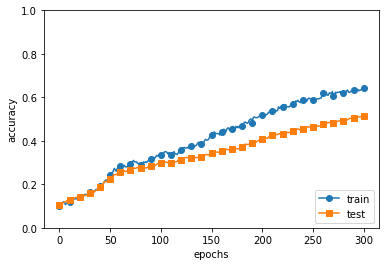

In [20]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show() 

### 6.5 하이퍼 파라미터 최적화

val acc:0.1 | lr:0.0002902286461117101, weight decay:4.800051146391788e-05
val acc:0.05 | lr:1.4762518623972477e-06, weight decay:2.438608251647166e-08
val acc:0.1 | lr:4.489095219286583e-05, weight decay:5.604902846188967e-07
val acc:0.66 | lr:0.00565789538658876, weight decay:1.51066924707305e-08
val acc:0.23 | lr:0.0015315804434834516, weight decay:3.345762437663285e-07
val acc:0.09 | lr:2.2468811258003014e-05, weight decay:2.572066917002802e-07
val acc:0.14 | lr:2.3869883853175817e-06, weight decay:7.287554610060546e-05
val acc:0.14 | lr:0.0002698237375980003, weight decay:1.5328492638003118e-05
val acc:0.13 | lr:1.8205087670584415e-05, weight decay:2.5642930622027576e-08
val acc:0.11 | lr:7.009650165686746e-05, weight decay:2.9210172509626734e-07
val acc:0.12 | lr:1.2057118272503232e-06, weight decay:5.638207370184911e-08
val acc:0.16 | lr:5.247594112309448e-06, weight decay:2.7337560730779906e-05
val acc:0.12 | lr:1.9145268191388308e-05, weight decay:4.340974395842586e-05
val acc

Best-16(val acc:0.38) | lr:0.0028009390701828067, weight decay:3.8796119391343335e-05
Best-17(val acc:0.35) | lr:0.0027195895434319996, weight decay:2.747282807687329e-05
Best-18(val acc:0.34) | lr:0.0023677054445928503, weight decay:2.461982677361923e-08
Best-19(val acc:0.28) | lr:0.0014913910389910145, weight decay:1.6731003294306624e-06
Best-20(val acc:0.23) | lr:0.0015315804434834516, weight decay:3.345762437663285e-07


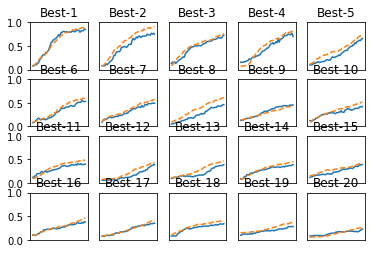

In [21]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show() 